# Sequence-to-Sequence Model with Frame-Level Discritisation

Herman Kamper, Stellenbosch University, 2018.

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))
sys.path.append(path.join("..", "embeddings"))

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE
import batching
import plotting
import samediff
import tflego
import training

output_dir = "/tmp/data-kamperh/"

## Data

In [3]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart1",
    "devpart1_utd_terms.mfcc.cmvn_dd.npz")
    )

# Data and labels
train_x = []
train_labels = []
speakers = set()
train_speakers = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    speaker = utt_key.split("_")[1][:3]
    train_labels.append(word)
    speakers.add(speaker)
    train_speakers.append(speaker)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 12021
E.g. item shape: (62, 39)


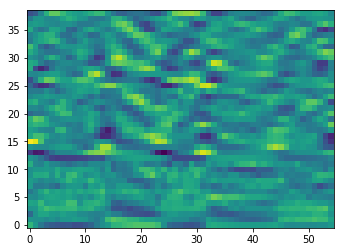

In [4]:
plt.imshow(train_x[3277].T, origin="bottom");

In [5]:
# Validation data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_speakers = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    speaker = utt_key.split("_")[1][:3]
    val_labels.append(word)
    speakers.add(speaker)
    val_speakers.append(speaker)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [6]:
# Convert speakers to integers
speaker_to_id = {}
id_to_speaker = {}
for i, speaker in enumerate(sorted(list(speakers))):
    speaker_to_id[speaker] = i
    id_to_speaker[i] = speaker
train_speaker_id = []
for speaker in train_speakers:
    train_speaker_id.append(speaker_to_id[speaker])
train_speaker_id = np.array(train_speaker_id, dtype=NP_ITYPE)
val_speaker_id = []
for speaker in val_speakers:
    val_speaker_id.append(speaker_to_id[speaker])
val_speaker_id = np.array(val_speaker_id, dtype=NP_ITYPE)

speaker_gender_dict = {
    "s01": "f", "s02": "f", "s03": "m", "s04": "f", "s05": "f", "s06": "m",
    "s07": "f", "s08": "f", "s09": "f", "s10": "m", "s11": "m", "s12": "f",
    "s13": "m", "s14": "f", "s15": "m", "s16": "f", "s17": "f", "s18": "f",
    "s19": "m", "s20": "f", "s21": "f", "s22": "m", "s23": "m", "s24": "m",
    "s25": "f", "s26": "f", "s27": "f", "s28": "m", "s29": "m", "s30": "m",
    "s31": "f", "s32": "m", "s33": "m", "s34": "m", "s35": "m", "s36": "m",
    "s37": "f", "s38": "m", "s39": "f", "s40": "m"
    }

In [7]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

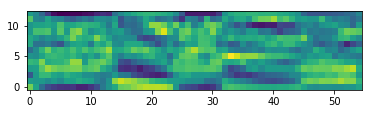

In [8]:
plt.imshow(train_x[3277].T, origin="bottom");

## Many-to-many sequence-to-sequence model with frame-level autoencoder

In [9]:
from tflego import *

def build_multi_many_to_many_latentfunc(x, x_lengths, enc_n_hiddens,
        dec_n_hiddens, build_latent_func, latent_func_kwargs, rnn_type="lstm",
        keep_prob=1., add_conditioning_tensor=None, **kwargs):
    """
    Multi-layer many-to-many model with a per-frame latent layer.

    A linear transformation is applied to the output of the decoder such that
    the final output dimensionality matches that of the input `x`. A generic
    latent layer is built according to the `build_latent_func` and
    `latent_func_kwargs` parameters.

    Parameters
    ----------
    x : Tensor [n_data, maxlength, d_in]
    build_latent_func : function
        The function to build the latent layer. The function's first parameter
        should be the input Tensor, and it should return a dictionary with an
        element "y" giving the output.
    latent_func_kargs : dict
        Arguments to pass on to `build_latent_func`.
    add_conditioning_tensor : Tensor [n_data, d_embedding]
        If provided, each time step of the decoder is conditioned on the 
        concatenation of the latent representation and this tensor.
    """

    maxlength = tf.reduce_max(x_lengths)
    n_output = x.get_shape().as_list()[-1]

    # Encoder
    encoder_output, encoder_states = build_multi_rnn(
        x, x_lengths, enc_n_hiddens, rnn_type, keep_prob,
        scope="rnn_encoder", **kwargs
        )

    # Latent transformation
    encoder_output_flattened = tf.reshape(
        encoder_output, [-1, enc_n_hiddens[-1]]
        )
    latent_layer = build_latent_func(
        encoder_output_flattened, **latent_func_kwargs
        )
    latent_layer_output = latent_layer["y"]
    d_latent_layer_output = latent_layer_output.get_shape().as_list()[-1]
    latent_layer_output = tf.reshape(latent_layer_output, [-1, maxlength, d_latent_layer_output])  # reshaped

    # Conditioning
    if add_conditioning_tensor is not None:
        d_conditioning_tensor = add_conditioning_tensor.get_shape().as_list()[-1]
        tiled_conditioning = tf.reshape(
            tf.tile(add_conditioning_tensor, [1, maxlength]), [-1, maxlength, d_conditioning_tensor]
            )
        decoder_input = tf.concat([latent_layer_output, tiled_conditioning], axis=-1)
    else:
        decoder_input = latent_layer_output
    
    # Decoder
    decoder_output, decoder_states = build_multi_rnn(
        decoder_input, x_lengths, dec_n_hiddens, rnn_type, keep_prob,
        scope="rnn_decoder", **kwargs
        )
    mask = tf.sign(tf.reduce_max(tf.abs(decoder_output), 2))

    # Final linear layer
    with tf.variable_scope("rnn_decoder/linear_output"):
        decoder_output = tf.reshape(decoder_output, [-1, dec_n_hiddens[-1]])
        decoder_output = build_linear(decoder_output, n_output)
        decoder_output = tf.reshape(decoder_output, [-1, maxlength, n_output])
        decoder_output *= tf.expand_dims(mask, -1)

    return {
        "encoder_output": encoder_output, "latent_layer": latent_layer, 
        "decoder_output": decoder_output, "mask": mask, "maxlength": maxlength
        }

### Autoencoder without speaker

In [10]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 20  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
n_input = d_frame
enc_n_hiddens = [10]
dec_n_hiddens = [10]
# dec_n_hiddens = [400 + d_speaker_embedding, 400, 400]
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130, # 130,
    "dec_n_hiddens": [], # [dec_n_hiddens[0]],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
intermediate_model_fn = path.join(output_dir, "many_to_many_ae.tmp.ckpt")
model_fn = path.join(output_dir, "many_to_many_ae.ckpt")

# Model

x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = build_multi_many_to_many_latentfunc(
    x, x_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type,
    add_conditioning_tensor=None
    )
encoder_output = network_dict["encoder_output"]
maxlength = network_dict["maxlength"]
ae = network_dict["latent_layer"]
z = tf.reshape(ae["z"], [-1, maxlength, latent_func_kwargs["n_z"]])
decoder_output = network_dict["decoder_output"]
mask = network_dict["mask"]

decoder_output *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x - decoder_output), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [72]:
np.random.seed(1)
train_batch_iterator = batching.SimpleBucketIterator(
    train_x, batch_size, n_buckets, True
    )
val_batch_iterator = batching.SimpleBucketIterator(
    val_x, batch_size, n_buckets, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x, x_lengths], loss, val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-12-11 07:19:29.883647
Epoch 0:
10.153 sec, train loss: 1.6060772, val loss: 1.2732178 *
Epoch 1:
10.725 sec, train loss: 1.1183618, val loss: 0.94658023 *
Epoch 2:
10.912 sec, train loss: 0.87507325, val loss: 0.80408245 *
Epoch 3:
9.378 sec, train loss: 0.7492024, val loss: 0.71484524 *
Epoch 4:
11.105 sec, train loss: 0.66433257, val loss: 0.6465176 *
Epoch 5:
9.288 sec, train loss: 0.59931827, val loss: 0.5892169 *
Epoch 6:
9.714 sec, train loss: 0.54443395, val loss: 0.5399518 *
Epoch 7:
8.875 sec, train loss: 0.4983905, val loss: 0.50025713 *
Epoch 8:
9.545 sec, train loss: 0.46029758, val loss: 0.46824583 *
Epoch 9:
11.205 sec, train loss: 0.42868724, val loss: 0.441734 *
Epoch 10:
9.869 sec, train loss: 0.40208435, val loss: 0.4195585 *
Epoch 11:
9.628 sec, train loss: 0.37964794, val loss: 0.40096977 *
Epoch 12:
9.609 sec, train loss: 0.36064285, val loss: 0.385244 *
Epoch 13:
10.650 sec, train loss: 0.34456593, val loss: 0.3718744 *
Epoch 14:
10.307 sec, train loss: 0.330

In [73]:
# Embed validation
val_batch_iterator = batching.SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [decoder_output], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/many_to_many_ae.ckpt


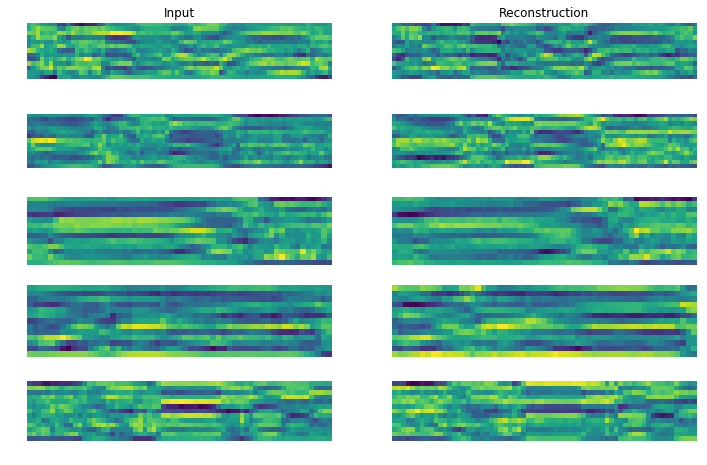

In [74]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

### Autoencoder with speaker

In [79]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 20  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
n_input = d_frame
n_speakers = max(speaker_to_id.values()) + 1
d_speaker_embedding = 1
enc_n_hiddens = [10]
dec_n_hiddens = [10]
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130, # 130,
    "dec_n_hiddens": [],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
intermediate_model_fn = path.join(output_dir, "many_to_many_ae.tmp.ckpt")
model_fn = path.join(output_dir, "many_to_many_ae.ckpt")

# Model

x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
speaker_id = tf.placeholder(TF_ITYPE, [None])

with tf.variable_scope("speaker_embedding"):
    speaker_embedding = tf.get_variable(
            "E", [n_speakers, d_speaker_embedding], dtype=TF_DTYPE,
            initializer=tf.contrib.layers.xavier_initializer()
            )
    embedding_lookup = tf.nn.embedding_lookup(speaker_embedding, speaker_id)

network_dict = build_multi_many_to_many_latentfunc(
    x, x_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type,
    add_conditioning_tensor=embedding_lookup
    )
encoder_output = network_dict["encoder_output"]
maxlength = network_dict["maxlength"]
ae = network_dict["latent_layer"]
z = tf.reshape(ae["z"], [-1, maxlength, latent_func_kwargs["n_z"]])
decoder_output = network_dict["decoder_output"]
mask = network_dict["mask"]

decoder_output *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x - decoder_output), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [80]:
class SimpleBucketSpeakerIterator(object):
    """An iterator with bucketing."""

    def __init__(self, x_list, speaker_ids, batch_size, n_buckets,
            shuffle_every_epoch=False):
        self.x_list = x_list
        self.speaker_ids = speaker_ids
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort([len(i) for i in x_list])
        bucket_size = int(len(self.x_lengths)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()
            
    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]
            batch_speakers = self.speaker_ids[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths, batch_speakers)

In [81]:
np.random.seed(1)
train_batch_iterator = SimpleBucketSpeakerIterator(
    train_x, train_speaker_id, batch_size, n_buckets, True
    )
val_batch_iterator = SimpleBucketSpeakerIterator(
    val_x, val_speaker_id, batch_size, n_buckets, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x, x_lengths, speaker_id], loss, val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-12-11 07:25:10.316486
Epoch 0:
11.372 sec, train loss: 1.3799086, val loss: 1.0428935 *
Epoch 1:
10.993 sec, train loss: 0.9144281, val loss: 0.86576384 *
Epoch 2:
10.605 sec, train loss: 0.76676905, val loss: 0.7546212 *
Epoch 3:
11.526 sec, train loss: 0.6618396, val loss: 0.6691175 *
Epoch 4:
10.934 sec, train loss: 0.58995503, val loss: 0.6042604 *
Epoch 5:
10.602 sec, train loss: 0.53412527, val loss: 0.55221415 *
Epoch 6:
9.486 sec, train loss: 0.48890242, val loss: 0.5086361 *
Epoch 7:
10.252 sec, train loss: 0.45059747, val loss: 0.47087514 *
Epoch 8:
11.608 sec, train loss: 0.4166687, val loss: 0.4371795 *
Epoch 9:
9.324 sec, train loss: 0.3866642, val loss: 0.40860793 *
Epoch 10:
9.796 sec, train loss: 0.36138612, val loss: 0.38477314 *
Epoch 11:
9.677 sec, train loss: 0.34008625, val loss: 0.36437455 *
Epoch 12:
10.912 sec, train loss: 0.32143527, val loss: 0.34656763 *
Epoch 13:
9.711 sec, train loss: 0.30465454, val loss: 0.33060065 *
Epoch 14:
11.405 sec, train loss:

In [69]:
# Embed validation
val_batch_iterator = batching.SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [decoder_output], feed_dict={x: np_x, x_lengths: np_x_lengths, speaker_id: np.array([3]*np_x.shape[0])}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/many_to_many_ae.ckpt


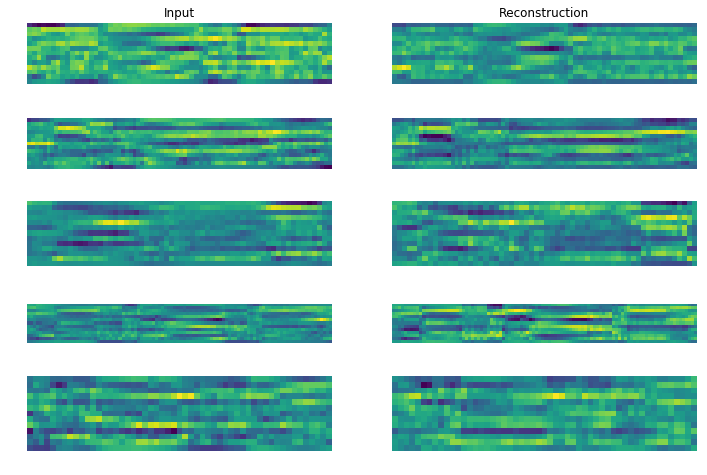

In [70]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

## Frame-level VQ-VAE 

In [18]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 20  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
n_input = d_frame
enc_n_hiddens = [100]
dec_n_hiddens = [100]
# dec_n_hiddens = [400 + d_speaker_embedding, 400, 400]
build_latent_func = tflego.build_vqvae
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 100,
    "dec_n_hiddens": [],
    "activation": tf.nn.relu,
    "K": 500
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
intermediate_model_fn = path.join(output_dir, "many_to_many_vqvae.tmp.ckpt")
model_fn = path.join(output_dir, "many_to_many_vqvae.ckpt")

# Model

x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = build_multi_many_to_many_latentfunc(
    x, x_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type,
    add_conditioning_tensor=None
    )
encoder_output = network_dict["encoder_output"]
maxlength = network_dict["maxlength"]
# ae = network_dict["latent_layer"]
vqvae = network_dict["latent_layer"]
embeds = vqvae["embeds"]
z_e = vqvae["z_e"]
z_q = vqvae["z_q"]
z_q_framelevel = tf.reshape(z_q, [-1, maxlength, latent_func_kwargs["n_z"]])
y = network_dict["decoder_output"]
mask = network_dict["mask"]
y *= tf.expand_dims(mask, -1)  # safety

# VQ-VAE loss: Gaussian
sigma_sq = 0.00001  # smaller values: care more about reconstruction
beta = 0.25
loss, recon_loss, vq_loss, commit_loss, train_op = tflego.vqvae_loss(
    x, z_e, z_q, embeds, y, learning_rate=learning_rate, sigma_sq=sigma_sq,
    beta=beta
    )
reconstruction_loss = tf.losses.mean_squared_error(x, y)

In [19]:
np.random.seed(1)
train_batch_iterator = batching.SimpleBucketIterator(
    train_x, batch_size, n_buckets, True
    )
val_batch_iterator = batching.SimpleBucketIterator(
    val_x, batch_size, n_buckets, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, train_op, [loss, recon_loss, vq_loss, reconstruction_loss], train_batch_iterator,
    [x, x_lengths], [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-12-12 07:01:26.984619
Epoch 0:
12.058 sec, train loss: [7.5733453e+04 7.5588719e+04 1.1577904e+02 1.5117743e+00], val loss: [7.0933055e+04 1.4157556e+00] *
Epoch 1:
11.963 sec, train loss: [5.9422938e+04 5.9266852e+04 1.2487405e+02 1.1853369e+00], val loss: [5.6084047e+04 1.1184634e+00] *
Epoch 2:
11.782 sec, train loss: [4.6882883e+04 4.6701516e+04 1.4508972e+02 9.3403035e-01], val loss: [4.7497285e+04 9.4617909e-01] *
Epoch 3:
11.764 sec, train loss: [4.1259059e+04 4.1044043e+04 1.7200545e+02 8.2088089e-01], val loss: [4.4471637e+04 8.8491607e-01] *
Epoch 4:
11.718 sec, train loss: [3.9763043e+04 3.9511660e+04 2.0110263e+02 7.9023314e-01], val loss: [4.5629105e+04 9.0740180e-01]
Epoch 5:
11.952 sec, train loss: [4.0241055e+04 3.9953340e+04 2.3017793e+02 7.9906672e-01], val loss: [4.5745102e+04 9.0889466e-01]
Epoch 6:
11.785 sec, train loss: [3.9496270e+04 3.9157000e+04 2.7141174e+02 7.8314006e-01], val loss: [4.4400648e+04 8.8080984e-01] *
Epoch 7:
11.700 sec, train loss: [3.864

In [20]:
# Embed validation
val_batch_iterator = batching.SimpleIterator(
    val_x[:10], len(val_x[:10]), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z_q_framelevel], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/many_to_many_vqvae.ckpt


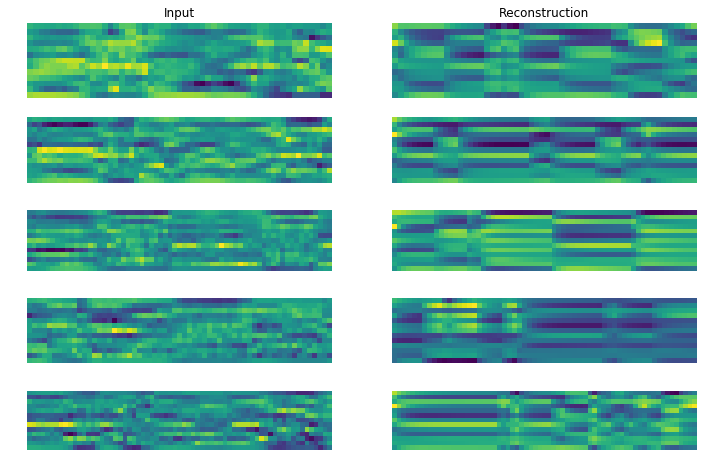

In [21]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

## Frame-level CatVAE

### Without speaker

In [22]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 20  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
n_input = d_frame
enc_n_hiddens = [100]
dec_n_hiddens = [100]
build_latent_func = tflego.build_catvae
K = 500  # 30
N = 1    # 4
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "dec_n_hiddens": [],
    "activation": tf.nn.relu,
    "K": K,
    "N": N,
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
intermediate_model_fn = path.join(output_dir, "many_to_many_catvae.tmp.ckpt")
model_fn = path.join(output_dir, "many_to_many_catvae.ckpt")

# Model

x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = build_multi_many_to_many_latentfunc(
    x, x_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type,
    add_conditioning_tensor=None
    )
encoder_output = network_dict["encoder_output"]
maxlength = network_dict["maxlength"]
catvae = network_dict["latent_layer"]
softmax_logits = catvae["softmax_logits"]
log_logits_categorical = catvae["log_logits_categorical"]
z = catvae["z"]
z_framelevel = tf.reshape(z, [-1, maxlength, latent_func_kwargs["K"]*latent_func_kwargs["N"]])
y = catvae["y"]
tau = catvae["tau"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]
y *= tf.expand_dims(mask, -1)  # safety

# Temperature
tau_init = 1.
tau_min = 0.1  # 1.
tau_list = np.linspace(tau_init, tau_min, n_epochs)

# Loss (KL divergence)
kl_tmp = tf.reshape(softmax_logits*(log_logits_categorical - tf.log(1.0/K)), [-1, N, K])
kl = tf.reduce_sum(kl_tmp, [1, 2])

# CatVAE loss (Gaussian)
sigma_sq = 0.00001
loss = 1./(2*sigma_sq)*tf.losses.mean_squared_error(x, y) + tf.reduce_mean(kl)
reconstruction_loss = tf.losses.mean_squared_error(x, y)

# # CatVAE loss (Bernoulli)
# y = tf.nn.sigmoid(y)
# loss = tf.reduce_mean(
#     -tf.reduce_sum(x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y), 1)
#     ) + tf.reduce_mean(kl)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [23]:
class SimpleBucketTemperatureIterator(object):
    """An iterator with bucketing and temperature."""
    
    i_epoch = 0

    def __init__(self, x_list, batch_size, n_buckets, temperature_list,
            shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.temperature_list = temperature_list
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort([len(i) for i in x_list])
        bucket_size = int(len(self.x_lengths)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()
            
    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()

        cur_temperature = self.temperature_list[SimpleBucketTemperatureIterator.i_epoch] if SimpleBucketTemperatureIterator.i_epoch < len(self.temperature_list) else self.temperature_list[-1]
        SimpleBucketTemperatureIterator.i_epoch += 1
            
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths, cur_temperature)

In [24]:
np.random.seed(1)
train_batch_iterator = SimpleBucketTemperatureIterator(
    train_x, batch_size, n_buckets, tau_list, True
    )
val_batch_iterator = SimpleBucketTemperatureIterator(
    val_x, batch_size, n_buckets, [tau_min], False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, [loss, reconstruction_loss, tau], train_batch_iterator,
    [x, x_lengths, tau], [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-12-12 07:09:51.521486
Epoch 0:
3.339 sec, train loss: [4.9027984e+04 9.8054868e-01 1.0000000e+00], val loss: [4.6999484e+04 9.3997616e-01] *
Epoch 1:
2.923 sec, train loss: [4.082781e+04 8.165275e-01 9.052633e-01], val loss: [4.1484418e+04 8.2964289e-01] *
Epoch 2:
2.907 sec, train loss: [3.2044785e+04 6.4083159e-01 8.1052601e-01], val loss: [3.3822707e+04 6.7637956e-01] *
Epoch 3:
2.924 sec, train loss: [2.5619404e+04 5.1231313e-01 7.1578968e-01], val loss: [2.990266e+04 5.979734e-01] *
Epoch 4:
2.908 sec, train loss: [2.2784277e+04 4.5560774e-01 6.2105238e-01], val loss: [2.7857963e+04 5.5707574e-01] *
Epoch 5:
2.925 sec, train loss: [2.1103721e+04 4.2199451e-01 5.2631575e-01], val loss: [2.6272730e+04 5.2536863e-01] *
Epoch 6:
2.928 sec, train loss: [1.9958432e+04 3.9908719e-01 4.3157887e-01], val loss: [2.4926363e+04 4.9843964e-01] *
Epoch 7:
2.937 sec, train loss: [1.9156701e+04 3.8305116e-01 3.3684227e-01], val loss: [2.3953252e+04 4.7897583e-01] *
Epoch 8:
2.924 sec, train 

In [25]:
# Embed validation
val_batch_iterator = batching.SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z_framelevel], feed_dict={x: np_x, x_lengths: np_x_lengths, tau: tau_min}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths, tau: tau_min}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/many_to_many_catvae.ckpt


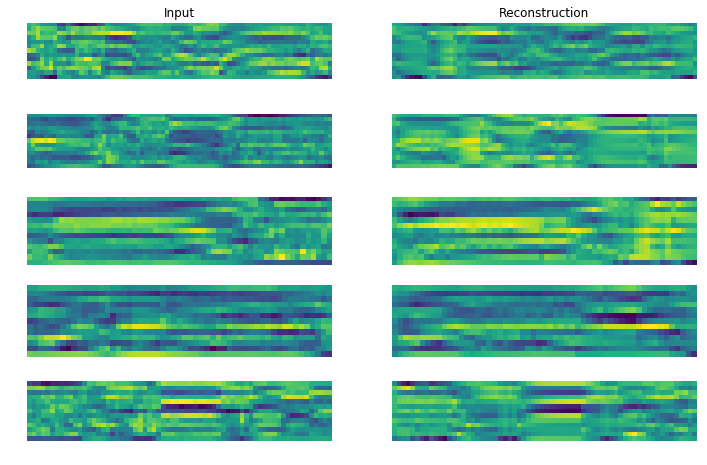

In [26]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

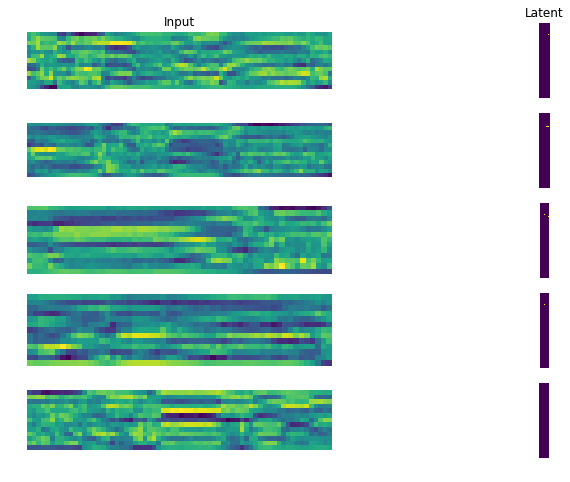

In [29]:
# Plot latent
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Latent")
    plt.imshow(np_z[i][:np_x_lengths[i]].T)
    plt.axis("off")

### With speaker

In [47]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 20  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
n_input = d_frame
n_speakers = max(speaker_to_id.values()) + 1
d_speaker_embedding = 10
enc_n_hiddens = [100]
dec_n_hiddens = [100]
build_latent_func = tflego.build_catvae
K = 30
N = 4
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "dec_n_hiddens": [],
    "activation": tf.nn.relu,
    "K": K,
    "N": N,
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
intermediate_model_fn = path.join(output_dir, "many_to_many_catvae_speaker.tmp.ckpt")
model_fn = path.join(output_dir, "many_to_many_catvae_speaker.ckpt")

# Model

x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
speaker_id = tf.placeholder(TF_ITYPE, [None])

with tf.variable_scope("speaker_embedding"):
    speaker_embedding = tf.get_variable(
            "E", [n_speakers, d_speaker_embedding], dtype=TF_DTYPE,
            initializer=tf.contrib.layers.xavier_initializer()
            )
    embedding_lookup = tf.nn.embedding_lookup(speaker_embedding, speaker_id)

network_dict = build_multi_many_to_many_latentfunc(
    x, x_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type,
    add_conditioning_tensor=embedding_lookup
    )
encoder_output = network_dict["encoder_output"]
maxlength = network_dict["maxlength"]
catvae = network_dict["latent_layer"]
softmax_logits = catvae["softmax_logits"]
log_logits_categorical = catvae["log_logits_categorical"]
z = catvae["z"]
z_framelevel = tf.reshape(z, [-1, maxlength, latent_func_kwargs["K"]*latent_func_kwargs["N"]])
y = catvae["y"]
tau = catvae["tau"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]
y *= tf.expand_dims(mask, -1)  # safety

# Temperature
tau_init = 1.
tau_min = 0.1  # 1.
tau_list = np.linspace(tau_init, tau_min, n_epochs)

# Loss (KL divergence)
kl_tmp = tf.reshape(softmax_logits*(log_logits_categorical - tf.log(1.0/K)), [-1, N, K])
kl = tf.reduce_sum(kl_tmp, [1, 2])

# CatVAE loss (Gaussian)
sigma_sq = 0.00001
loss = 1./(2*sigma_sq)*tf.losses.mean_squared_error(x, y) + tf.reduce_mean(kl)
reconstruction_loss = tf.losses.mean_squared_error(x, y)

# # CatVAE loss (Bernoulli)
# y = tf.nn.sigmoid(y)
# loss = tf.reduce_mean(
#     -tf.reduce_sum(x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y), 1)
#     ) + tf.reduce_mean(kl)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [43]:
class SimpleBucketTemperatureSpeakerIterator(object):
    """An iterator with bucketing and temperature."""
    
    i_epoch = 0

    def __init__(self, x_list, batch_size, n_buckets, temperature_list,
            speaker_ids, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.temperature_list = temperature_list
        self.speaker_ids = speaker_ids
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort([len(i) for i in x_list])
        bucket_size = int(len(self.x_lengths)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()
        
        SimpleBucketTemperatureIterator.i_epoch = 0
            
    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()

        cur_temperature = self.temperature_list[SimpleBucketTemperatureIterator.i_epoch] if SimpleBucketTemperatureIterator.i_epoch < len(self.temperature_list) else self.temperature_list[-1]
        SimpleBucketTemperatureIterator.i_epoch += 1
            
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]
            batch_speakers = self.speaker_ids[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths, cur_temperature, batch_speakers)

In [59]:
np.random.seed(1)
train_batch_iterator = SimpleBucketTemperatureSpeakerIterator(
    train_x, batch_size, n_buckets, tau_list, train_speaker_id, True
    )
val_batch_iterator = SimpleBucketTemperatureSpeakerIterator(
    val_x, batch_size, n_buckets, [tau_min], val_speaker_id, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, [loss, reconstruction_loss, tau], train_batch_iterator,
    [x, x_lengths, tau, speaker_id], [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-12-11 08:49:27.855680
Epoch 0:
42.604 sec, train loss: [5.309374e+04 1.061887e+00 1.000000e+00], val loss: [6.6766570e+04 1.3353386e+00] *
Epoch 1:
44.581 sec, train loss: [3.9203766e+04 7.8406572e-01 9.0526330e-01], val loss: [5.4573359e+04 1.0914493e+00] *
Epoch 2:
51.258 sec, train loss: [3.0493062e+04 6.0983741e-01 8.1052601e-01], val loss: [4.7989059e+04 9.5975506e-01] *
Epoch 3:
46.183 sec, train loss: [2.5918303e+04 5.1833802e-01 7.1578968e-01], val loss: [4.554029e+04 9.107719e-01] *
Epoch 4:
46.007 sec, train loss: [2.3259984e+04 4.6516761e-01 6.2105238e-01], val loss: [4.3733883e+04 8.7464213e-01] *
Epoch 5:
46.238 sec, train loss: [2.1677996e+04 4.3352765e-01 5.2631575e-01], val loss: [4.3046574e+04 8.6089545e-01] *
Epoch 6:
44.810 sec, train loss: [2.0521848e+04 4.1040403e-01 4.3157887e-01], val loss: [4.2790180e+04 8.5576606e-01] *
Epoch 7:
41.839 sec, train loss: [1.9777379e+04 3.9551353e-01 3.3684227e-01], val loss: [4.186677e+04 8.372965e-01] *
Epoch 8:
41.946 sec,

In [71]:
# Embed training data
# batch_iterator = SimpleBucketTemperatureSpeakerIterator(
#     val_x, len(val_x), 1, [tau_min], val_speaker_id, False
#     )
batch_iterator = SimpleBucketTemperatureSpeakerIterator(
    train_x, len(train_x), 1, [tau_min], train_speaker_id, False
    )
# labels = [val_labels[i] for i in batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths, batch_tau, batch_speaker_id in batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z_framelevel], feed_dict={x: np_x, x_lengths: np_x_lengths, tau: batch_tau, speaker_id: batch_speaker_id}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths, tau: batch_tau, speaker_id: batch_speaker_id}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/many_to_many_catvae_speaker.ckpt


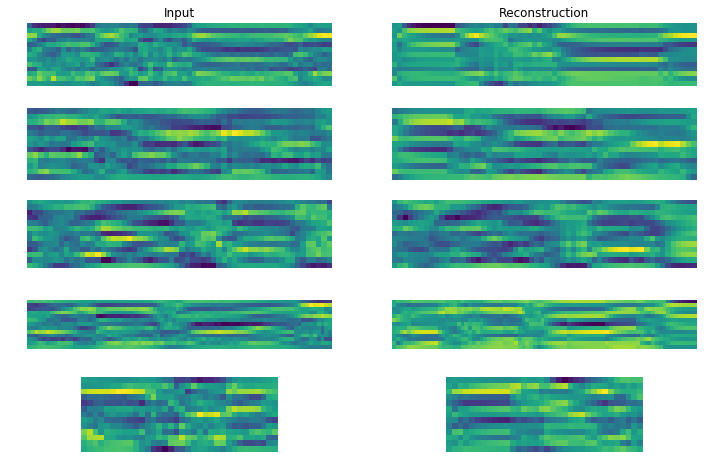

In [72]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

### Training on entire utterances

In [32]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "subsets", "devpart1",
    "devpart1.mfcc.cmvn_dd.npz")
    )

# Data and labels
train_x = []
#train_labels = []
speakers = set()
train_speakers = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    #word = "_".join(utt_key.split("_")[:-2])
    speaker = utt_key.split("_")[0][:3]
    #train_labels.append(word)
    speakers.add(speaker)
    train_speakers.append(speaker)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 24401
E.g. item shape: (19, 39)


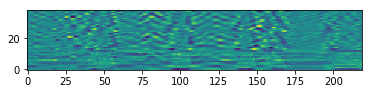

In [33]:
plt.imshow(train_x[3277].T, origin="bottom");

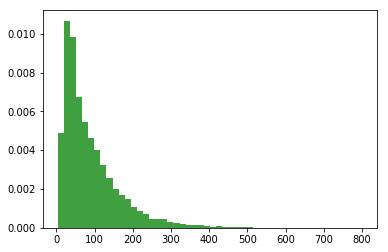

In [36]:
n, bins, patches = plt.hist(train_lengths, 50, density=True, facecolor='g', alpha=0.75);

In [37]:
# Validation data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_speakers = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    speaker = utt_key.split("_")[1][:3]
    val_labels.append(word)
    speakers.add(speaker)
    val_speakers.append(speaker)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [38]:
# Convert speakers to integers
speaker_to_id = {}
id_to_speaker = {}
for i, speaker in enumerate(sorted(list(speakers))):
    speaker_to_id[speaker] = i
    id_to_speaker[i] = speaker
train_speaker_id = []
for speaker in train_speakers:
    train_speaker_id.append(speaker_to_id[speaker])
train_speaker_id = np.array(train_speaker_id, dtype=NP_ITYPE)
val_speaker_id = []
for speaker in val_speakers:
    val_speaker_id.append(speaker_to_id[speaker])
val_speaker_id = np.array(val_speaker_id, dtype=NP_ITYPE)

speaker_gender_dict = {
    "s01": "f", "s02": "f", "s03": "m", "s04": "f", "s05": "f", "s06": "m",
    "s07": "f", "s08": "f", "s09": "f", "s10": "m", "s11": "m", "s12": "f",
    "s13": "m", "s14": "f", "s15": "m", "s16": "f", "s17": "f", "s18": "f",
    "s19": "m", "s20": "f", "s21": "f", "s22": "m", "s23": "m", "s24": "m",
    "s25": "f", "s26": "f", "s27": "f", "s28": "m", "s29": "m", "s30": "m",
    "s31": "f", "s32": "m", "s33": "m", "s34": "m", "s35": "m", "s36": "m",
    "s37": "f", "s38": "m", "s39": "f", "s40": "m"
    }

In [39]:
# Truncate and limit dimensionality
max_length = 500
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

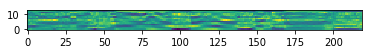

In [40]:
plt.imshow(train_x[3277].T, origin="bottom");

In [44]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 20  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
n_input = d_frame
n_speakers = max(speaker_to_id.values()) + 1
d_speaker_embedding = 10
enc_n_hiddens = [100]
dec_n_hiddens = [100]
build_latent_func = tflego.build_catvae
K = 512 # 30
N = 1 # 4
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "dec_n_hiddens": [],
    "activation": tf.nn.relu,
    "K": K,
    "N": N,
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
intermediate_model_fn = path.join(output_dir, "many_to_many_catvae_speaker.tmp.ckpt")
model_fn = path.join(output_dir, "many_to_many_catvae_speaker.ckpt")

# Model

x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
speaker_id = tf.placeholder(TF_ITYPE, [None])

with tf.variable_scope("speaker_embedding"):
    speaker_embedding = tf.get_variable(
            "E", [n_speakers, d_speaker_embedding], dtype=TF_DTYPE,
            initializer=tf.contrib.layers.xavier_initializer()
            )
    embedding_lookup = tf.nn.embedding_lookup(speaker_embedding, speaker_id)

network_dict = build_multi_many_to_many_latentfunc(
    x, x_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type,
    add_conditioning_tensor=embedding_lookup
    )
encoder_output = network_dict["encoder_output"]
maxlength = network_dict["maxlength"]
catvae = network_dict["latent_layer"]
softmax_logits = catvae["softmax_logits"]
log_logits_categorical = catvae["log_logits_categorical"]
z = catvae["z"]
z_framelevel = tf.reshape(z, [-1, maxlength, latent_func_kwargs["K"]*latent_func_kwargs["N"]])
y = catvae["y"]
tau = catvae["tau"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]
y *= tf.expand_dims(mask, -1)  # safety

# Temperature
tau_init = 1.
tau_min = 0.1  # 1.
tau_list = np.linspace(tau_init, tau_min, n_epochs)

# Loss (KL divergence)
kl_tmp = tf.reshape(softmax_logits*(log_logits_categorical - tf.log(1.0/K)), [-1, N, K])
kl = tf.reduce_sum(kl_tmp, [1, 2])

# CatVAE loss (Gaussian)
sigma_sq = 0.00001
loss = 1./(2*sigma_sq)*tf.losses.mean_squared_error(x, y) + tf.reduce_mean(kl)
reconstruction_loss = tf.losses.mean_squared_error(x, y)

# # CatVAE loss (Bernoulli)
# y = tf.nn.sigmoid(y)
# loss = tf.reduce_mean(
#     -tf.reduce_sum(x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y), 1)
#     ) + tf.reduce_mean(kl)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [45]:
np.random.seed(1)
train_batch_iterator = SimpleBucketTemperatureSpeakerIterator(
    train_x, batch_size, n_buckets, tau_list, train_speaker_id, True
    )
val_batch_iterator = SimpleBucketTemperatureSpeakerIterator(
    val_x, batch_size, n_buckets, [tau_min], val_speaker_id, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, [loss, reconstruction_loss, tau], train_batch_iterator,
    [x, x_lengths, tau, speaker_id], [loss, reconstruction_loss], val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-12-12 07:33:25.998671
Epoch 0:
19.407 sec, train loss: [3.0523479e+04 6.1045557e-01 1.0000000e+00], val loss: [3.9736805e+04 7.9469430e-01] *
Epoch 1:
19.090 sec, train loss: [1.9685727e+04 3.9367396e-01 9.0526319e-01], val loss: [2.9702209e+04 5.9397829e-01] *
Epoch 2:
18.906 sec, train loss: [1.4420662e+04 2.8836313e-01 8.1052679e-01], val loss: [2.566157e+04 5.131571e-01] *
Epoch 3:
18.799 sec, train loss: [1.1911479e+04 2.3817638e-01 7.1578968e-01], val loss: [2.3357695e+04 4.6707630e-01] *
Epoch 4:
18.691 sec, train loss: [1.0709182e+04 2.1412836e-01 6.2105209e-01], val loss: [2.1721320e+04 4.3434614e-01] *
Epoch 5:
18.849 sec, train loss: [1.0181130e+04 2.0356609e-01 5.2631617e-01], val loss: [2.0704477e+04 4.1400728e-01] *
Epoch 6:
18.876 sec, train loss: [9.9353838e+03 1.9864987e-01 4.3157920e-01], val loss: [2.0016854e+04 4.0025306e-01] *
Epoch 7:
19.051 sec, train loss: [9.8060244e+03 1.9606143e-01 3.3684200e-01], val loss: [1.9642111e+04 3.9275655e-01] *
Epoch 8:
19.094

In [47]:
# Embed validation data
batch_iterator = SimpleBucketTemperatureSpeakerIterator(
    val_x, len(val_x), 1, [tau_min], val_speaker_id, False
    )
# batch_iterator = SimpleBucketTemperatureSpeakerIterator(
#     train_x, len(train_x), 1, [tau_min], train_speaker_id, False
#     )
# labels = [val_labels[i] for i in batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths, batch_tau, batch_speaker_id in batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z_framelevel], feed_dict={x: np_x, x_lengths: np_x_lengths, tau: batch_tau, speaker_id: batch_speaker_id}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths, tau: batch_tau, speaker_id: batch_speaker_id}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/many_to_many_catvae_speaker.ckpt


In [48]:
# Embed and save
embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]
np.savez_compressed("discrete.npz", **embed_dict)

The saved archive above can be evaluated in the `samediff/` directory:

    cd /home/samediff
    ./run_calcdists.sh ../notebooks/discrete.npz
    ./run_samediff.sh ../notebooks/discrete.npz

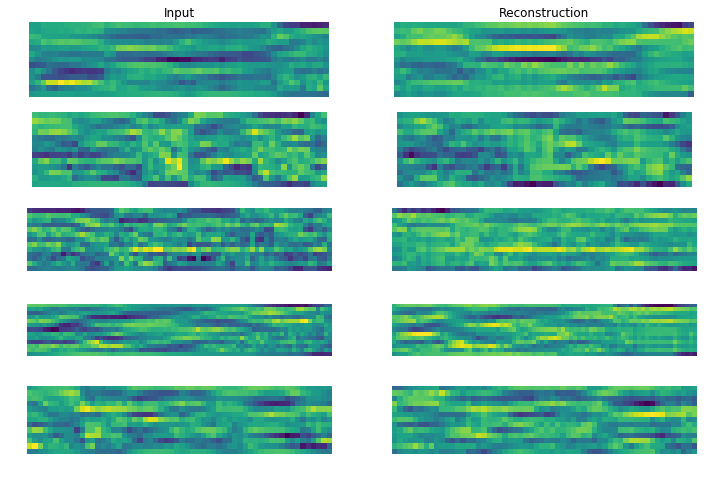

In [68]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

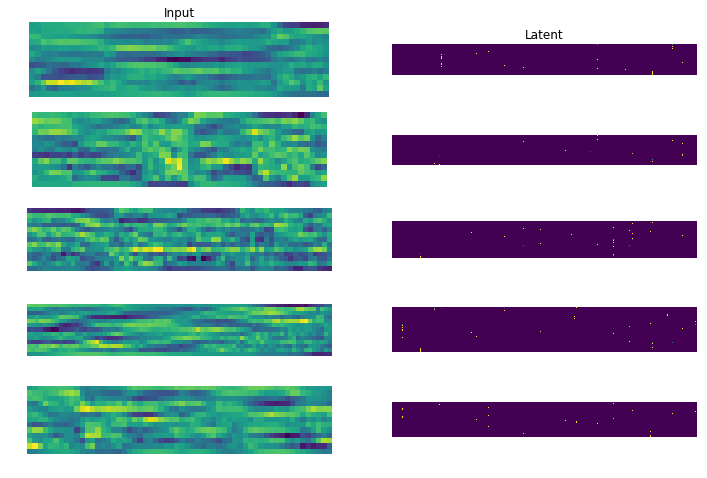

In [72]:
# Plot latent
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Latent")
    plt.imshow(np_z[i][:np_x_lengths[i]])
    plt.axis("off")

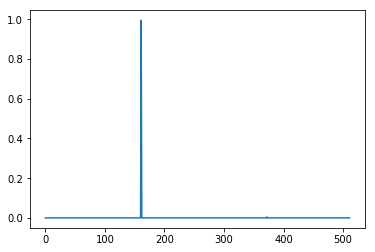

In [74]:
i_frame = 9
plt.plot(np_z[i][i_frame]);